# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [4]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
compare-deeplibs.ipynb	dataマウントテンプレ.ipynb  dataset  week3-EDA


In [6]:
# これ以降はターミナルと同様にディレクトリを扱える
cd drive/dataset

/content/drive/dataset


In [7]:
ls

House Prices_data/        Mercedes-Benz Greener Manufacturing/    Titanic/
Instacart Market Basket/  Porto Seguro’s Safe Driver Prediction/


In [8]:
cd Titanic

/content/drive/dataset/Titanic


In [65]:
ls

gender_submission.csv  test.csv  train.csv


# EDA課題５

# タイタニックデータ科学ソリューション

---
ここは半広告なので無視
### I have released a new Python package [Speedml](https://speedml.com) which codifies the techniques used in this notebook into an intuitive, powerful, and productive API. 

### Speedml helps me jump from low 80% on the Kaggle leaderboard to high 20% within few iterations.

### One more thing... Speedml achieves this with nearly 70% fewer lines of code!

### Run and download the [Titanic Solution using Speedml](https://github.com/Speedml/notebooks/blob/master/titanic/titanic-solution-using-speedml.ipynb).

---

This notebook is a companion to the book [Data Science Solutions](https://www.amazon.com/Data-Science-Solutions-Startup-Workflow/dp/1520545312). The notebook walks us through a typical workflow for solving data science competitions at sites like Kaggle.

There are several excellent notebooks to study data science competition entries. However many will skip some of the explanation on how the solution is developed as these notebooks are developed by experts for experts. The objective of this notebook is to follow a step-by-step workflow, explaining each step and rationale for every decision we take during solution development.

##ワークフローの段階

競合ソリューションのワークフローは、Data Science Solutionsの書籍で説明されている7つの段階を経ています。

1. 質問または問題の定義。
2. トレーニングとテストのデータを取得する。
3. データの編成、準備、浄化。
4. パターンを分析し、データを探索する。
5. モデルを作成し、問題を予測し、解決します。
6. 問題解決のステップと最終的な解決策を視覚化し、報告し、提示する。
7. 結果を提供または提出する。


## 質問と問題の定義

Kaggleのような競技会場では、解決すべき問題や質問する項目を定義し、データサイエンスモデルを訓練するためのデータセットを提供し、テストデータセットに対してモデル結果をテストします。タイタニックサバイバル競技の質問または問題の定義は、Kaggleに説明されています。

> タイタニック災害から生き残った、または生き残っていない乗客を列挙したトレーニングセットを知ることにより、テストデータセット内のこれらの乗客が生存しているかどうかにかかわらず、モデルは生存情報を含まない所定のテストデータセットに基づいて決定できます。

私たちはまた、問題の領域について早期に理解を深めたいと思うかもしれません。これはKaggleの競技の説明ページに記載されています。これらは注目すべきハイライトです。

- 1912年4月15日に、タイタニック号は彼女の処女航海中に氷山に衝突して沈んで、2224人の乗客と乗組員のうち1502人が死亡した。言い換えると、32％の生存率です。
- この難破船が生命の喪失につながった原因の1つは、乗客と乗組員に十分な救命艇がなかったことです。
- 沈没を生き延びるには何らかの運があったにもかかわらず、女性、子供、上層階など、他の人よりも生き残る可能性が高いグループもあった。

## ワークフローの目標

データ科学ソリューションのワークフローは、7つの主要な目標を解決します

**分類** 私たちはサンプルを分類または分類したいと思うかもしれません。また、さまざまなクラスとソリューションの目標との関連性や相関性を理解したい場合もあります。

**相関** トレーニングデータセット内の利用可能な機能に基づいて問題を理解することができます。データセット内のどの機能がソリューションの目標に大きく貢献していますか？統計的に言えば、機能とソリューションのゴールには相関がありますか？特徴量の値が変化すると、ソリューションの状態も変わりますが、その逆もあります。これは、与えられたデータセットの数値的および分類的特徴の両方についてテストすることができます。また、後続の目標やワークフローの段階で、生存以外の機能の相関を判断することもできます。特定の特徴量を関連付けることは、特徴量の作成、完了、または修正に役立ちます。

**変換** モデリング段階では、データを準備する必要があります。モデルアルゴリズムの選択に応じて、すべての特徴を数値相当の値に変換する必要があるかもしれない。たとえば、テキストのカテゴリ値を数値に変換する場合です。

**完結** データの準備では、特徴量の欠損値を推定する必要があります。モデルアルゴリズムは、欠損値がない場合に最も効果的です。

**修正する** 与えられた訓練データセットを分析して、特徴量内のエラーまたはおそらく無価値な値を分析し、これらの値を是正するか、またはエラーを含むサンプルを除外します。これを行うための1つの方法は、サンプルまたは特徴量の間で異常値を検出することです。分析に貢献していない場合、または結果に著しい歪みが生じている場合、特徴を完全に破棄することもあります。

**作成** 既存の特徴または特徴量のセットに基づいて新しい特徴を作成して、特徴量が相関、変換、完全性の目標に従うようにすることはできますか。

**チャート作成** データの性質とソリューション目標に応じて、適切な視覚化プロットとグラフを選択する方法。

リファクタリングリリース2017年1月29日
（a）読者からのコメント、（b）Jupyterカーネル（2.7）からKaggleカーネル（3.5）へのノートブックのポーティング、および（c）ベストプラクティスカーネルのレビューに基づいて、ノートブックを大幅にリファクタリングしています。

ユーザーのコメント
データセット全体のタイトルを数値に変換するなど、特定の操作のためのトレーニングデータとテストデータを組み合わせます。（感謝@シャランナリボール）
正しい観察 - 約30％の乗客が兄弟および/または配偶者を乗せていた。（ありがとう@Reinhard）
ロジスティック回帰係数を正しく解釈する。（ありがとう@Reinhard）
移植に関する問題
プロットの寸法を指定し、凡例をプロットに表示します。
ベストプラクティス
プロジェクトの早い段階で機能相関分析を実行する。
可読性のためにオーバーレイの代わりに複数のプロットを使用する。

In [0]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## machine learning
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰

from sklearn.svm import SVC, LinearSVC
# サポートベクターマシン

from sklearn.ensemble import RandomForestClassifier
# ランダムフォレスト

from sklearn.neighbors import KNeighborsClassifier
# K近傍法(多クラス分類)

from sklearn.naive_bayes import GaussianNB
# ナイーブベイズ分類器

from sklearn.linear_model import Perceptron
# パーセプトロン

from sklearn.linear_model import SGDClassifier
# SGD クラス分類に用いるタイプ

from sklearn.tree import DecisionTreeClassifier
# 決定木


## データを取得する

Python Pandasパッケージは、私たちのデータセットで作業するのに役立ちます。まず、Pandas DataFramesにトレーニングデータセットとテストデータセットを取得します。また、これらのデータセットを組み合わせて、両方のデータセットで特定の操作を実行します。

In [0]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

## 書かれているデータを分析

Pandasはまた、プロジェクトの早い段階で質問に答えるデータセットを判断するのに役立ちます。

### どのデータが今後利用できそうなやつか！？

これらを直接操作または分析するための機能名に注目してください。これらの機能名はKaggleのデータページに記載されています。

 [Kaggle data page here](https://www.kaggle.com/c/titanic/data).

In [123]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**どの欄がカテゴリになっていますか？**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

これらの値は、サンプルを同様のサンプルのセットに分類する。カテゴリフィーチャには、公称、序数、比率、または間隔に基づく値があります。とりわけ、これは視覚化に適したプロットを選択するのに役立ちます。

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.
- カテゴリ：生き残り、セックス、そして乗船した港。序数：Pclass。

**どの欄が数値ですか？**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

どの機能が数値ですか？これらの値はサンプルごとに変化します。数値フィーチャ内に離散、連続、または時系列の値がありますか？とりわけ、これは視覚化に適したプロットを選択するのに役立ちます。

- Continous: Age, Fare. Discrete: SibSp, Parch.
- 連続：年齢、運賃。離散：SibSp、Parch。

In [124]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**どの欄が混合データ型ですか？**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

同じ特徴内の数値の英数字データ。これらは目標を修正するための候補になります。

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.
- チケットは、数字と英数字のデータ型が混在しています。部屋番号は英数字です。

**どの欄にエラーや誤植が含まれている可能性がありますか？**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

これは大規模なデータセットを検討するのは難しいですが、小さなデータセットからいくつかのサンプルを見直すと、どの機能を修正する必要があるかがわかります。

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.
- 名前欄には、タイトルや丸括弧、代替名や短縮名に使用される引用符など、名前を記述するためのいくつかの方法があるため、エラーや誤植が含まれる可能性があります。

In [125]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**blank, null or empty valuesを含む欄**

これらは修正が必要です

- Cabin> Age> Embarked欄には、トレーニングデータセットの順序でいくつかのNull値が含まれています。
- 部屋番号>テストデータセットの場合、年齢は不完全です。

**さまざまな欄のデータ型は何ですか？**

Helping us during converting goal.
これにより目標の修正を助けてくれます

- Seven features are integer or floats. Six in case of test dataset.
- 7つの欄は、整数または浮動小数点数です。テストデータセットの場合は6つ。
- Five features are strings (object).
- 5つの欄は文字列（オブジェクト）です。

In [126]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

**サンプル全体で数値的な欄のその値の分布はどうですか？**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

describe()によって、これは、初期のEDAの最中でも、実際の問題領域においてトレーニングデータセットがどれほど代表的であるかを判断するのに役立ちます。

- 合計サンプルは、タイタニック号（2,224）に搭乗した乗客の実際の数のうちの891人で、つまり40％です。
- 生き残ったのは、0または1の値を持つカテゴリ的な欄です。
- 実際の生存率の32％に対して、約38％のサンプルが生き残ったことになっている。
- ほとんどの乗客（> 75％）は親または子供と一緒に居なかった。
- 乗客のほぼ30％が兄弟姉妹や配偶者を乗せていました。
- 運賃は、乗客数が1％未満の場合、512ドルもの高い料金で大幅に変動しました。
- 年齢範囲65-80歳の高齢者（<1％）はほとんど居ませんでした。

In [127]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**カテゴリの欄の分布はどうですか？**

- 名前はデータセット全体で一意です（count = unique = 891）
- 性別変数は65％男性（上位=男性、頻度= 577 /カウント= 891）との2つの可能な値である。
- 客室の値はいくつかのサンプルにわたって二重になっています。あるいは、複数の乗客が客室を共有しました。
- Embarkedは3つの可能な値を取ります。ほとんどの乗客が使用するのはSポート（top = S）
- チケット機能は、重複値（ユニーク= 681）の比率（22％）が高いです。

In [128]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Johnston, Mr. Andrew G",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


### データ分析に基づく仮定

これまでに行われたデータ分析に基づいて、以下の前提に着きました。適切な措置を講じる前に、これらの前提条件をさらに検証することがあります。

**相関する**

私たちは、各機能がどのように生き残りと相関しているかを知りたいと思っています。プロジェクトの早い段階でこの作業を行い、プロジェクトの後半でモデル化された相関関係とこれらの迅速な相関関係を一致させたいと考えています。

**完了します。**

1. 生存と年齢の相関図を出す
2. 生存と乗船した港の相関図を出す

**修正する**

1. 重複率（22％）が高く、チケットと生存率との間に相関がない可能性があるため、チケットの特徴は分析から除外される可能性があります。
2. キャビンフィーチャは、トレーニングデータとテストデータセットの両方で非常に不完全であるか、または多くのnull値を含んでいるため、削除される可能性があります。
3. 生存に寄与しないため、PassengerIDはトレーニングデータセットから削除される可能性があります。
4. 名前機能は比較的非標準であり、生存に直接貢献しない可能性があります。

**作成.**

1. 私たちはParchとSibSpに基づいてFamilyという新しい機能を作成して、家族の総数を取得することができます。
2. タイトル機能を新しい機能として抽出するために、名前機能を設計することができます。
3. 年齢層の新しい機能を作りたいと思うかもしれません。これは、連続的な数値的特徴を序数的カテゴリー的特徴に変える。
4. また、分析に役立つ場合は、Fare範囲機能を作成することもできます。

**分類**

また、前に述べた問題の記述に基づいて、私たちの前提に追加することもあります。

1. 女性（性別=女性）は生き残った可能性が高かった。
2. 小児（年齢<？）は生存していた可能性が高い。
3. 上位クラスの乗客（Pclass = 1）は生き残った可能性が高い。

## ピボット機能による分析

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

私たちの観測と仮定の一部を確認するために、欄の相互関係を素早く相互にピボットすることで、欄の相関関係を素早く分析できます。この段階では空の値を持たない欄に対してのみ行うことができます。また、カテゴリ（性別）、順序（Pclass）または離散（SibSp、Parch）タイプの機能に対してのみ、そうすることが理にかなっています。

- **Pclass** 我々はPclass = 1とSurvived（分類＃3）の間に有意な相関（> 0.5）を観察する。この機能をモデルに含めることにしました。
- **Sex** 問題の定義の中で、性別=女性の生存率が74％（分類＃1）と非常に高いことを確認しました。
- **SibSp and Parch** これらの機能は、特定の値に対してゼロの相関関係を持ちます。これらの個々の欄から欄または欄のセットを導出することが最善の方法です（＃1を作成する）。

In [129]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# groupby = データの集計機能。グルーピング結果にまとめて関数を適用するなど。

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [130]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [131]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [132]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## データを視覚化して分析する

今度は、データを分析するための視覚化を使用して、いくつかの前提を確認していきます。

### 数値欄の相関

数値フィーチャとソリューション目標（Survived）との相関を理解することから始めましょう。

ヒストグラムチャートは、バンディングや範囲が有用なパターンを特定するのに役立つAgeのような連続的な数値変数を分析するのに便利です。ヒストグラムは、自動的に定義されたビンまたは等間隔のバンドを使用したサンプルの分布を示すことができます。これは、特定のバンドに関する質問に答えるのに役立ちます（例えば、幼児の生存率はより良いですか？）

ヒストグラム視覚化におけるx軸は、サンプルまたは乗客の数を表すことに注意してください。

**観察**

- 幼児（年齢4歳以下）は高い生存率を示した。
- 最も古い乗客（年齢= 80）は生き残った。
- 多数の15〜25歳の生存者はいませんでした。
- ほとんどの乗客は15-35歳の範囲にあります。

**決定**

この単純な分析により、後続のワークフローステージの決定として、前提条件が確認されます。

- 私たちはモデルトレーニングで年齢（＃2の私たちの仮定）を考慮する必要があります。
-  Null値の年齢欄を完了します（＃1を完了します）。
- 私たちは年齢層をまとめるべきです（＃3を作る）。

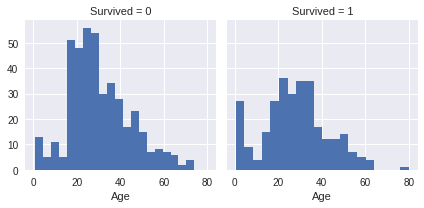

In [133]:
g = sns.FacetGrid(train_df, col='Survived')
# 属性ごとに一気にグラフ化を行う手法は『Facet』 [https://qiita.com/hik0107/items/865b75ae486728cb0006]
  
g.map(plt.hist, 'Age', bins=20)

### 数値と序数の欄の相関

1つのプロットを使用して相関を識別する複数の機能を組み合わせることができます。これは、数値を持つ数値的および類型的な欄を用いて行うことができる。

**観察**

-Pclass = 3がほとんどの乗客を持っていたが、ほとんどが生き残れなかった。私たちの分類の仮定＃2を確認します。
- Pclass = 2およびPclass = 3の幼児乗客はほとんどが生き残った。さらに、我々の分類する仮定＃2を満たす。
- Pclass = 1のほとんどの乗客は生き残った。私たちの分類の仮定＃3を確認します。
- Pclassは、乗客の年齢分布に関して変化する。

**決定**

- モデルトレーニングのためにPclassを検討してください。

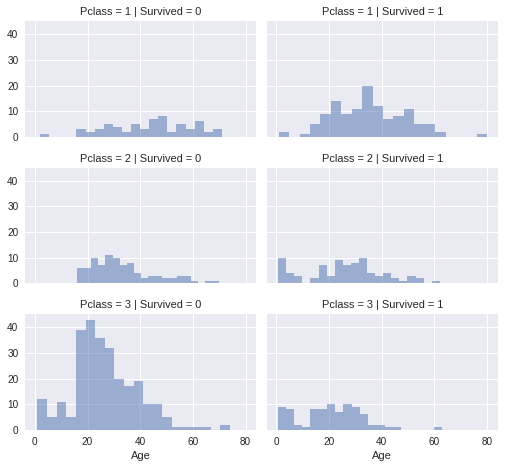

In [134]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### カテゴリの欄の相関

これで、カテゴリの機能とソリューションの目標を関連付けることができます。

**観察**

- 女性の乗客は男性よりはるかに良好な生存率を示した。分類を確認します（＃1）。
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- 男性の生存率が高いEmbarked = Cという例外。これは、PclassとEmbarked、Pclass と Survivedの間の相関性であり、必ずしもEmbarkedとSurvivedの間の直接的な相関関係ではない。
- 男性は、CおよびQポートでPclass = 2と比較した場合、Pclass = 3で良好な生存率を示した。完了（＃2）。
- 乗船港は、Pclass = 3および男性乗客の生存率が異なる。相関（＃1）。

**決定**

- セックス機能をモデルトレーニングに追加します。
- モデルトレーニングにEmbarked機能を追加して追加します。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


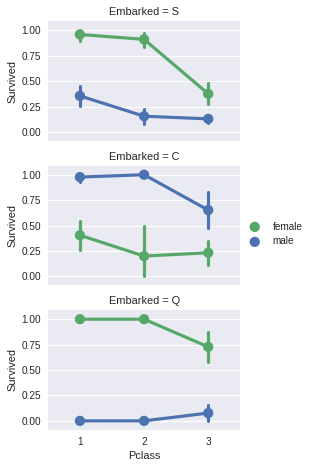

In [135]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### カテゴリと数値の相関

また、（数値以外の値を持つ）カテゴリフィーチャと数値フィーチャを関連付けることもできます。私たちは、受動態（カテゴリー非数値）、性別（カテゴリー非数値）、運賃（数値連続）、生存（カテゴリカル数値）と相関させることを検討できます。

**観察**

- より高い運賃を支払う乗客はより良い生存をしました。運賃の範囲（＃4）を作成するという前提を確認します。
- 乗船港は生存率と相関する。相関（＃1）と完了（＃2）を確認します。

**決定**

- Fare機能のバンディングを検討してください。

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


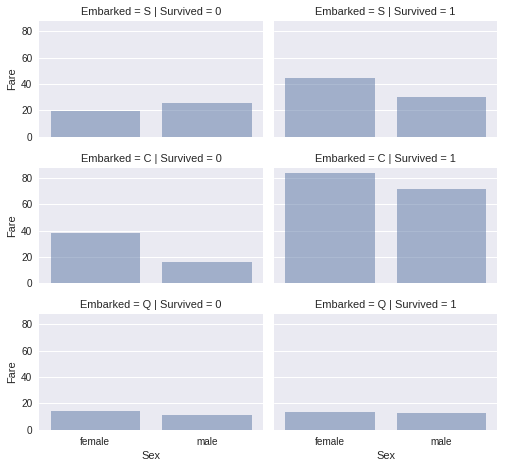

In [136]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## データラングリング

これまで、データセットと問題要件に関するいくつかの仮説と結論を集めました。 これまでは、単一の特徴量や値を変更してこれらに到達する必要はありませんでしたが、これからは結論と仮説を実行して、特徴量を補完したり修正したり作成したしていきましょう。

### 特徴量を削除することで修正する

特徴量を削除することで、データポイントの数が減少し、分析をより楽にすることができます。

仮説と結論に基づいて、CabinとTicketの特徴量を削除しましょう。

該当する項目では、訓練データセットとテストデータセットの両方で操作を実行して、一貫性を保ちます。

In [137]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

### 既存のものから新しい特徴量を作成する

NameとPassengerIdを削除する前に、NameからTitle(肩書)を抽出し、TitleとSurvivedの相関関係を調べたいと思います。

次のコードでは、正規表現を使用してTitleを抽出します。 正規表現パターン (\w+\.)は、Name特徴量内のドット文字で終わる最初の単語と一致します。 expand = FalseフラグはDataFrameを返します。

**観察**

Title、年齢、生存率をプロットすると、次のような観察結果が得られます。

- ほとんどのTitleは、年齢層を正確に区別します。 例：Master の年齢平均は5歳です。
- Title年齢層の生存率はわずかに異なります。
- 一部のTitleはほとんどが生き残った（Mme、Lady、Sir）か、そうでなかった（Don、Rev、Jonkheer）。

**結論**

- モデルトレーニングのために新しいタイトル特徴量を留め置くことに決めました。

In [138]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


多くのTitleをより一般的な名前に置き換えることも、「Rare」として分類することもできます

In [139]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


カテゴリカルなタイトルを序数に変換することができます。

In [140]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
# 欠損値を他の値に置換（穴埋め）するにはfillna()メソッドを使う。

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


これで、トレーニングとテストのデータセットからNameを安全に削除できます。 また、トレーニングデータセットにPassengerIdは必要ありません。生き残ったかどうかという問題とはどう考えても関係ないですよね。

In [141]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### カテゴリカル特徴量の変換

文字列を含む特徴量を数値に変換できます。 この操作は、ほとんどのモデルアルゴリズムで必要で、特徴量の補完を成し遂げることに貢献してくれます。

Sex特徴量を、女性= 1、男性= 0の性別という新しい特徴量に変換してみましょう。

In [142]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### 連続的数値の特徴量を補完する

今度は、欠損値またはnull値を持つ特徴量を、その欠損値を推定して補完する必要があります。まず、age特徴量でこれを行います。

数値連続的特徴量を補完するのに、ここでは3つの方法が考えられます。

1. 簡単な方法は、平均と標準偏差の間の乱数を生成することです。

2. 欠損値を推測するより正確な方法は、他の相関する特徴量を使用することです。今回のケースでは、年齢、性別、およびPclassの間の相関を記録する。 PclassとGenderの特徴量の組み合わせのセット全体でageの中央値を使用してAgeの値を推測します。Pclass = 1、Gender = 0、Pclass = 1、Gender = 1などの中間の年齢などなど。

3. 方法1と2を組み合わせる。中央値に基づいて年齢値を推測する代わりに、PclassとGenderの組み合わせのセットに基づいて、平均と標準偏差の間になる乱数を使用する

方法1と3はランダムノイズをモデルに導入することになり、複数回の実行結果が異なる可能性があります。よって方法2を優先します。

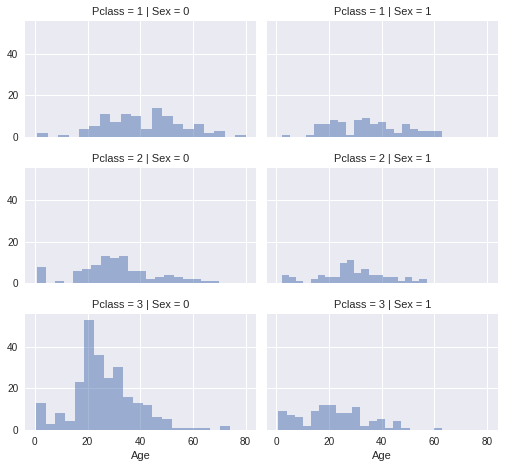

In [143]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Pclass x Genderの組み合わせに基づいて推測されたAge値を格納する為の、空の配列を準備することから始めましょう。

In [144]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

今度は、Sex（0または1）とPclass（1,2,3）を繰り返し、6つの組み合わせのAgeの推測値を計算します。

In [145]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Ageの区間(Band)を作成し、Survivedとの相関を見てみましょう。

In [146]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


これらの区間に基づいて年齢を序数に置き換えましょう。

In [147]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

 # df.loc は行ラベルを指定しデータを参照する方法 http://ailaby.com/lox_iloc_ix/

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


AgeBand特徴量を削除します。

In [148]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### 既存の特徴量を組み合わせて新しい特徴量を作成する

ParchとSibSpを組み合わせてFamilySizeとして新しい特徴量を作成できます。 これにより、データセットからParchとSibSpを削除できます。

In [149]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


IsAloneという別の特徴量を作成することができます。

In [150]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


IsAloneが良さげなので、Parch、SibSp、およびFamilySize特徴量を削除します。

In [151]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


PclassとAgeを組み合わせた人工的な特徴を作成することもできます。

In [152]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### カテゴリカル特徴量を補完する

Embarked特徴量は、乗船港に基づいてS、Q、Cの値を取ります。 トレーニングデータセットには2つの欠損値がありますが、今回は最も一般的な出現で埋めることにします。

In [153]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

# 欠損値を除外（削除）するdf.dropna()
# pandas.df.mode は各列・各行の最頻値を取得できる

'S'

In [154]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### カテゴリカル特徴量を数値に変換する

欠損値を補完したので、Embarked特徴量を数値に変換出来るようになりました。

In [155]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### クイック補完と数値特徴量の変換

この特徴量の最頻値（最も頻繁に登場する値）を使用して、テストデータセットの値が不足している場合に、Fare特徴量を補完することができます。 これは1行のコードで行えます。

補完する目的は、欠損値を埋めて、モデルアルゴリズムがある程度望ましい状態で動作することです。必要以上に欠損値の推測に時間を掛ける必要はありません。

In [156]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


FareBand特徴量を作成することもできます。

In [157]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


FareBandに基づいてFare特徴量を序数に変換します。

In [158]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


テストセットは以下の通り。

In [159]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## モデル化、予測、解決

これで、モデルをトレーニングし、必要なソリューションを予測する準備が整いました。60以上の予測モデリングアルゴリズムがあります。我々が評価できるいくつかの選択されたモデルに絞るためには、問題の種類と解決策の要件を理解する必要があります。私たちの問題は、分類と回帰の問題です。他の変数や特徴（性別、年齢、ポートなど）との関係（生存しているか否か）を特定したい。私たちは、与えられたデータセットでモデルを訓練しているので、教師あり学習と呼ばれる機械学習のカテゴリーにも通っています。これらの2つの基準（教師あり学習と分類と回帰）では、モデルの選択肢をいくつかに絞り込むことができます。これらには、

ロジスティック回帰  
KNNまたはk-Nearest Neighbors  
サポートベクターマシン  
ナイーブベイズ分類器  
意思決定ツリー  
ランダムフォレスト  
パーセプトロン  
人工ニューラルネットワーク  
RVMまたは関連性ベクトルマシン

In [160]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

ロジスティック回帰は、ワークフローの早期に実行するのに便利なモデルです。ロジスティック回帰は、累積ロジスティック分布であるロジスティック関数を使用して確率を推定することによって、カテゴリ依存変数（特徴）と1つ以上の独立変数（特徴）との間の関係を測定する。

トレーニングデータセットに基づいてモデルによって生成された信頼スコアに注目してください。

In [161]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

ロジスティック回帰を使用して、欄作成と目標達成のための前提と決定を検証できます。これは、決定関数内の特徴の係数を計算することによって行うことができる。

正の係数は応答の対数 - オッズを増加させ（したがって確率を増加させる）、負の係数は応答の対数 - オッズを減少させる（したがって確率を減少させる）。

性別値が高いほど（男性：0〜女性：1）、生存確率= 1が最も高くなります。
逆にPclassが増加すると、Survived = 1の確率が最も低下します。
このように、Age * Classは、Survivedと2番目に高い負の相関を持つため、モデル化するための優れた人工的な機能です。
2番目に高い正の相関としてタイトルも同様です。

In [162]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201527
5,Title,0.398234
2,Age,0.287163
4,Embarked,0.261762
6,IsAlone,0.129140
3,Fare,-0.085150
7,Age*Class,-0.311200
0,Pclass,-0.749007


次に、分類および回帰分析に使用されるデータを分析する関連する学習アルゴリズムを備えた監視学習モデルであるサポートベクターマシンを使用してモデル化します。訓練サンプルの集合を考えると、それぞれが1かの他に属しているとしてマークされた二つのカテゴリは、SVMの学習アルゴリズムが非確率的2元線形分類器作り、一つのカテゴリまたはその他に新しい試験サンプルを割り当てたモデルを構築します。

モデルはロジスティック回帰モデルよりも高い信頼スコアを生成することに注意してください。

In [163]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.84

パターン認識において、k-Nearest Neighborsアルゴリズム（または略してk-NN）は、分類および回帰に使用される非パラメトリックな方法である。サンプルは、その近隣のものの多数決によって分類され、そのサンプルは、k個の最近傍（kは正の整数、通常は小さい）の中で最も一般的なクラスに割り当てられる。k = 1の場合、オブジェクトはその単一の最近傍のクラスに単純に割り当てられます。参照Wikipedia。

KNN信頼スコアはロジスティック回帰よりも良いがSVMより悪い。

In [164]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

機械学習では、ナイーブベイズ分類子は、ベイズの定理に特徴間の強い（素朴な）独立性仮定を適用した単純な確率的分類子のファミリーです。Naive Bayes分類器はスケーラビリティが高く、学習問題の変数（フィーチャ）数に線形のパラメータが必要です。

モデル生成信頼スコアはこれまでに評価されたモデルの中で最も低い。

In [165]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

パーセプトロンは、バイナリ分類器（数字のベクトルで表される入力が特定のクラスに属するかどうかを決定する関数）の教師付き学習のアルゴリズムです。線形分類器の一種であり、線形予測子関数に基づく予測を特徴ベクトルと組み合わせる分類アルゴリズムである。このアルゴリズムはオンライン学習を可能にし、訓練セット内の要素を一度に1つずつ処理する。

In [166]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


78.0

In [167]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.01

In [168]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


79.01

このモデルでは、フィーチャ（ツリーブランチ）をターゲット値（ツリーの葉）に関する結論にマッピングする予測モデルとしてデシジョンツリーを使用します。ターゲット変数が有限の値セットを取ることができるツリーモデルは、分類ツリーと呼ばれます。これらの木構造では、葉はクラスラベルを表し、枝はそれらのクラスラベルにつながる特徴の接続詞を表す。ターゲット変数が連続した値（通常は実数）を取ることができるディシジョンツリーは、回帰ツリーと呼ばれます。

モデル信頼スコアはこれまでに評価されたモデルの中で最も高い。

In [169]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

次のモデルのランダムフォレストは最も人気のあるものの1つです。ランダムフォレストまたはランダム決定フォレストは、トレーニング時に多数の決定木（n_estimators = 100）を構築し、クラス（分類）のモードであるクラスを出力することによって動作する分類、回帰および他のタスクのアンサンブル学習方法であり、または個々の樹木の平均予測（回帰）を含む。参照Wikipedia。

モデル信頼スコアはこれまでに評価されたモデルの中で最も高い。このモデルの出力（Y_pred）を使用して、競争結果の提出を作成します。

In [170]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

### モデル評価

すべてのモデルの評価をランク付けして、問題のために最良のモデルを選ぶことができます。Decision TreeとRandom Forestのスコアは同じですが、Random Forestを使用することに決めました。決定木がトレーニングセットにあふれてしまう習慣を修正するためです。

In [171]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
0,Support Vector Machines,83.84
2,Logistic Regression,80.36
6,Stochastic Gradient Decent,79.01
7,Linear SVC,79.01
5,Perceptron,78.00
4,Naive Bayes,72.28


In [0]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
# submission.to_csv('../output/submission.csv', index=False)

競争サイトKaggleへの提出は、6,082件の競技エントリーのうち3,883件を獲得します。この結果は、競技会が進行中であることを示しています。この結果は、提出データセットの一部を占めるに過ぎません。私たちの最初の試みには悪くない。私たちのスコアを改善するための提案は、大歓迎です。

## 参考文献

このノートブックは、タイタニックの競技やその他の情報源を解決した素晴らしい仕事に基づいて作成されています。

- [A journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic)
- [Getting Started with Pandas: Kaggle's Titanic Competition](https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests)
- [Titanic Best Working Classifier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)

 # My メモ
複数の機械学習手法を一つ一つモデルを作っていますが、Kfoldを利用するといっぺんに作れるのでそうします  
例えば以下の方法を参考にできるようです。
https://qiita.com/kibinag0/items/1a29db61fcb8c527d952